In [1]:
import multiprocessing
import time
import numpy as np
import scipy as sp
import emcee
import testkit
import ciamod
import settings
import os
import gc
import sys
import pickle
from scipy.io.idl import readsav
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import TPmod
import forwardmodel
from IPython.display import display
%matplotlib inline


In [2]:
# First get data and parameters for object

# get the observed spectrum
obspec = np.asfortranarray(np.loadtxt("G570D_2MHcalib.dat",dtype='d',unpack='true'))

# start with the wavelength range
w1 = 1.0
w2 = 2.5


# How many patches & clouds do we want??
# Must be at least 1 of each, but can turn off cloud below
npatches = 2
nclouds = 1

# set up array for setting patchy cloud answers
do_clouds = np.zeros([npatches],dtype='i')

# Which patches are cloudy
do_clouds[0] = 0
do_clouds[1] = 1
# set up cloud detail arrays
cloudnum = np.zeros([npatches,nclouds],dtype='i')
cloudtype =np.zeros([npatches,nclouds],dtype='i')

print(cloudtype.size)
# Now fill cloud details. What kind of clouds and shape are they?
# Cloud types
# 1:  slab cloud
# 2: deep thick cloud , we only see the top
# 3: slab with fixed thickness log dP = 0.005 (i.e. fits within a single layer)
# 4: deep thick cloud with fixed height (i.e. appears in a single layer)
# In both cases the cloud properties are density, rg, rsig for real clouds
# and dtau, w0, and power law for cloudnum = 89 or 99 for grey
cloudnum[:,0] = 5
cloudtype[:,0] = 1

#cloudnum[:,1] = 2
#cloudtype[:,1] = 1

#cloudnum[:,2] = 2
#cloudtype[:,2] = 2

# second patch turn off top cloud
#cloudnum[1,0] = 5
#cloudtype[1,0] = 0

#cloudnum[1,1] = 5
#cloudtype[1,1] = 0


# gravity??
logg = 4.0

# distance (parsecs)
dist =5.882

# scale factor r2d2 from distance 1 Rj radius
r2d2 = (71492e3)**2. / (dist * 3.086e+16)**2.

# Are we doing H- bound-free, free-free continuum opacities?
# (Is the profile going above approx 3000K in the photosphere?)
do_bff = 1

chemeq = 0

# Set the profile type. If we're using a fixed one. Give the file name
proftype = 9
pfile = "t1700g1000f3.dat"


# set up pressure grids in bar cos its intuitive
logcoarsePress = np.arange(-4.0, 2.5, 0.53)
logfinePress = np.arange(-4.0, 2.4, 0.1)
# forward model wants pressure in bar
#logcoarsePress = np.arange(-4.0, 3.0, 0.5)
coarsePress = pow(10,logcoarsePress)
press = pow(10,logfinePress)
nlayers = press.size

# Where are the cross sections?
# give the full path
xpath = "../Linelists/"

# now the cross sections

# Now list the gases.
# If Na is after K, at the end of the list, alkalis will be tied
# together at Asplund solar ratio. See Line at al (2015)
# Else if K is after Na, they'll be separate

gaslist = ['h2o','ch4']
ngas = len(gaslist)

# some switches for alternative cross sections
# Use Mike's Alkalis?
malk = 1
# Use Mike's CH4?
mch4 = 0

fwhm = 0
# Are we using DISORT for radiative transfer?
# (HINT: Not in this century)
use_disort = 0 

# use the fudge factor?
do_fudge = 1




2


In [3]:
print(obspec.shape)
print(press)

(3, 371)
[1.00000000e-04 1.25892541e-04 1.58489319e-04 1.99526231e-04
 2.51188643e-04 3.16227766e-04 3.98107171e-04 5.01187234e-04
 6.30957344e-04 7.94328235e-04 1.00000000e-03 1.25892541e-03
 1.58489319e-03 1.99526231e-03 2.51188643e-03 3.16227766e-03
 3.98107171e-03 5.01187234e-03 6.30957344e-03 7.94328235e-03
 1.00000000e-02 1.25892541e-02 1.58489319e-02 1.99526231e-02
 2.51188643e-02 3.16227766e-02 3.98107171e-02 5.01187234e-02
 6.30957344e-02 7.94328235e-02 1.00000000e-01 1.25892541e-01
 1.58489319e-01 1.99526231e-01 2.51188643e-01 3.16227766e-01
 3.98107171e-01 5.01187234e-01 6.30957344e-01 7.94328235e-01
 1.00000000e+00 1.25892541e+00 1.58489319e+00 1.99526231e+00
 2.51188643e+00 3.16227766e+00 3.98107171e+00 5.01187234e+00
 6.30957344e+00 7.94328235e+00 1.00000000e+01 1.25892541e+01
 1.58489319e+01 1.99526231e+01 2.51188643e+01 3.16227766e+01
 3.98107171e+01 5.01187234e+01 6.30957344e+01 7.94328235e+01
 1.00000000e+02 1.25892541e+02 1.58489319e+02 1.99526231e+02]


In [4]:
# Now we'll get the opacity files into an array
totgas = 24
gasdata = []
with open('gaslistR10K.dat') as fa:
     for line_aa in fa.readlines()[1:totgas+1]:
        line_aa = line_aa.strip()
        gasdata.append(line_aa.split())
list1 = []    
for i in range(0,ngas):
    for j in range(0,totgas):
            if (gasdata[j][1].lower() == gaslist[i].lower()):
                list1.append(gasdata[j])


    
if (malk == 1):
    for i in range (0,ngas):    
        list1[i] = [w.replace('K_xsecs.pic', 'K_Mike_xsecs.pic') for w in list1[i]]
        list1[i] = [w.replace('Na_xsecs.pic', 'Na_Mike_xsecs.pic') for w in list1[i]]

if (mch4 ==1):
    for i in range (0,ngas):    
        list1[i] = [w.replace('CH4_xsecs.pic', 'CH4_Mike_xsecs.pic') for w in list1[i]]
    

lists = [xpath+i[3] for i in list1[0:ngas]]
gasnum = np.asfortranarray(np.array([i[0] for i in list1[0:ngas]],dtype='i'))
print(lists)
print(gasnum)

['../Linelists/h2o_ucl2017_xsecs_R10K.pic', '../Linelists/ch4_xsecs_R10K.pic']
[1 2]


In [5]:
# get the basic framework from water list
rawwavenum, inpress, inlinetemps, inlinelist = pickle.load( open(xpath+'/crh_xsecs_R10K.pic', "rb" ) )

wn1 = 10000./w2
wn2 = 10000. / w1
inwavenum = np.asfortranarray(rawwavenum[np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1)))],dtype='float64')
ntemps = inlinetemps.size
npress= press.size
nwave = inwavenum.size
r1 = np.amin(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))
r2 = np.amax(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))

# Here we are interpolating the linelist onto our fine pressure scale.
# pickles have linelist as 4th entry....
linelist = (np.ones([ngas,npress,ntemps,nwave],order='F')).astype('float64', order='F')
for gas in range (0,ngas):
    inlinelist= pickle.load( open(lists[gas], "rb" ) )[3]
    for i in range (0,ntemps):
        for j in range (r1,r2+1):
            pfit = interp1d(np.log10(inpress),np.log10(inlinelist[:,i,j]))
            linelist[gas,:,i,(j-r1)] = np.asfortranarray(pfit(np.log10(press)))

linelist[np.isnan(linelist)] = -50.0


In [6]:
print(gasnum.shape)
print(linelist.shape)

(2,)
(2, 64, 27, 9163)


In [7]:
# Get the cia bits
tmpcia, ciatemps = ciamod.read_cia("CIA_DS_aug_2015.dat",inwavenum)
cia = np.asfortranarray(np.empty((4,ciatemps.size,nwave)),dtype='float32')
cia[:,:,:] = tmpcia[:,:,:nwave] 
ciatemps = np.asfortranarray(ciatemps, dtype='float32')


In [8]:
# Sort out the BFF opacity stuff and chemical equilibrium tables:
metscale,coscale,Tgrid,Pgrid,gasnames,abunds = pickle.load(open("chem_eq_tables_P3K.pic", "rb"))
nlayers = press.shape[0]
nabpress = Pgrid.size
nabtemp = Tgrid.size
nabgas = abunds.shape[4]
nmet = metscale.size
nco = coscale.size



bff_raw = np.zeros([nabtemp,nlayers,3])
gases_myP = np.zeros([nmet,nco,nabtemp,nlayers,ngas+3])
gases = np.zeros([nmet,nco,nabtemp,nabpress,ngas+3])

if (chemeq == 0):
    # Just want the ion fractions for solar metallicity in this case
    ab_myP = np.empty([nabtemp,nlayers,nabgas])
    i1 = np.where(metscale == 0.0)
    i2 = np.where(coscale == 1.0)
    for gas in range (0,nabgas):
        for i in range (0,nabtemp):
            pfit = InterpolatedUnivariateSpline(Pgrid,np.log10(abunds[i1[0],i2[0],i,:,gas]),k=1)
            ab_myP[i,:,gas] = pfit(np.log10(press))
            
            bff_raw = np.zeros([nabtemp,nlayers,3])
            bff_raw[:,:,0] = ab_myP[:,:,0]
            bff_raw[:,:,1] = ab_myP[:,:,2]
            bff_raw[:,:,2] = ab_myP[:,:,4]

else:
    # In this case we need the rows for the gases we're doing and ion fractions
    gases[:,:,:,:,0] = abunds[:,:,:,:,0]
    gases[:,:,:,:,1] = abunds[:,:,:,:,2]
    gases[:,:,:,:,2] = abunds[:,:,:,:,4]
    nmatch = 0 
    for i in range(0,ngas):
        for j in range(0,nabgas):
            if (gasnames[j].lower() == gaslist[i].lower()):
                gases[:,:,:,:,i+3] = abunds[:,:,:,:,j]
                nmatch = nmatch + 1
    if (nmatch != ngas):
        print("you've requested a gas that isn't in the Vischer table. Please chaeck and try again.")
        exit
    
    for i in range(0,nmet):
        for j in range(0,nco):
            for k in range(0,ngas+3):
                for l in range(0,nabtemp):
                    pfit = InterpolatedUnivariateSpline(Pgrid,np.log10(gases[i,j,l,:,k]),k=1)
                    gases_myP[i,j,l,:,k] = pfit(np.log10(press))
    


ceTgrid = Tgrid


In [9]:
# for proftype = 2 with no clouds, ndim = nprof + ngas-1, + (dlam,beta,logg, r2d2)
ndim = 17 #(nprof + (ngas-1) + 9)
p0 = np.empty(ndim)
print(ndim)
theta = p0

17


In [10]:

p0[0] = (0.5*np.random.randn()) - 3.5 # H2O
p0[1] = (0.5*np.random.randn()) - 4.0 # CO
#p0[2] = (0.5*np.random.randn()) - 4.0 # CO2
#p0[3] = (0.5*np.random.randn()) - 4.0 # CH4
#p0[4] = (0.5*np.random.randn()) - 8.0 # TiO
#p0[5] = (0.5*np.random.randn()) - 8.0 # VO
#p0[6] = (0.5*np.random.randn()) - 8.0 # CrH
#p0[7] = (1.0*np.random.randn()) - 8.0 # FeH
#p0[8] = (0.5*np.random.randn()) - 8.0 # H2S
#p0[9] = (0.5*np.random.randn()) - 5.5 # Na+K
p0[2] = 0.1*np.random.randn() + 4.9  # gravity
p0[3] = r2d2 + (np.random.randn() * (0.1*r2d2))  # scale factor
p0[4] = np.random.randn() * 0.001  # dlambda
p0[5] = np.log10((np.random.rand() * (max(obspec[2,:]**2)*(0.1 - 0.01))) + (0.01*min(obspec[2,10::3]**2)))
# patch
p0[6] = np.random.rand()
# Slab cloud params
p0[7] = np.random.rand()
p0[8] = np.random.randn()
p0[9] = np.random.rand()
p0[10] = 0.1*np.random.randn()
p0[11] = np.random.rand()
# Slab cloud params
#p0[12] = np.random.rand()
#p0[13] = np.random.randn()
#p0[14] = np.random.rand()
#p0[15] = np.random.randn()
#p0[16] = 0.1*np.random.rand()
#
# Deck cloud params
#p0[17] = np.random.randn()
#p0[18] = np.random.rand()
#p0[19] = np.random.randn()
#p0[20] = np.abs(0.1 + 0.01*np.random.randn())
p0[12] = 0.39 + 0.1*np.random.randn()
p0[13] = 0.14 +0.05*np.random.randn()
p0[14] = -1.2 + 0.2*np.random.randn()
p0[15] = 2.25+ 0.2*np.random.randn()
p0[16] = 4200. + (500.*  np.random.randn())

#while True:
#    Tcheck = TPmod.set_prof(proftype, coarsePress, press, p0[ndim-5:])
#    if min(Tcheck) > 1.0:
#        break
#    else:
#        p0[ndim-5] = 0.39 + 0.01*np.random.randn()
#        p0[ndim-4] = 0.14 + 0.01*np.random.randn()
#        p0[ndim-3] = -1.2 + 0.2*np.random.randn()
#        p0[ndim-2] = 2. + 0.2*np.random.randn()
#        p0[ndim-1] = 4200. + (200.*np.random.randn())
    

In [11]:
print(theta) 

[-3.79582214e+00 -3.52088822e+00  4.75791362e+00  1.50222647e-19
  7.90806763e-04 -3.25301000e+01  8.74101361e-02  8.57659143e-01
  8.31325451e-01  6.03416682e-01 -3.60590744e-01  4.45131318e-01
  4.26940890e-01  1.86882973e-01 -1.32010167e+00  2.36017001e+00
  3.97249631e+03]


In [12]:
prof = theta[ndim-5:]
if (proftype == 9):
    modP,modT = np.loadtxt(pfile,skiprows=1,usecols=(1,2),unpack=True)
    tfit = InterpolatedUnivariateSpline(np.log10(modP),modT,k=1)
    prof = tfit(logcoarsePress)


In [13]:
settings.init()
settings.runargs = gases_myP,chemeq,dist, cloudtype,do_clouds,gasnum,cloudnum,inlinetemps,coarsePress,press,inwavenum,linelist,cia,ciatemps,use_disort,fwhm,obspec,proftype,do_fudge, prof,do_bff,bff_raw,ceTgrid,metscale,coscale


In [14]:
print(do_clouds)
print(gasnum)
print(cloudnum)
print(cloudtype)
#print theta[15]
#print theta[16]
r2d2= theta[3]
logg = theta[2]
D = 3.086e+16 * dist
R = np.sqrt(r2d2) * D
g = (10.**logg)/100.
M = (R**2 * g/(6.67E-11))/1.898E27
print(R/70000e3, M)

[0 1]
[1 2]
[[5]
 [5]]
[[1]
 [1]]
1.0050568006199632 22.39076173838315


Text(0.5, 0, 'T/K')

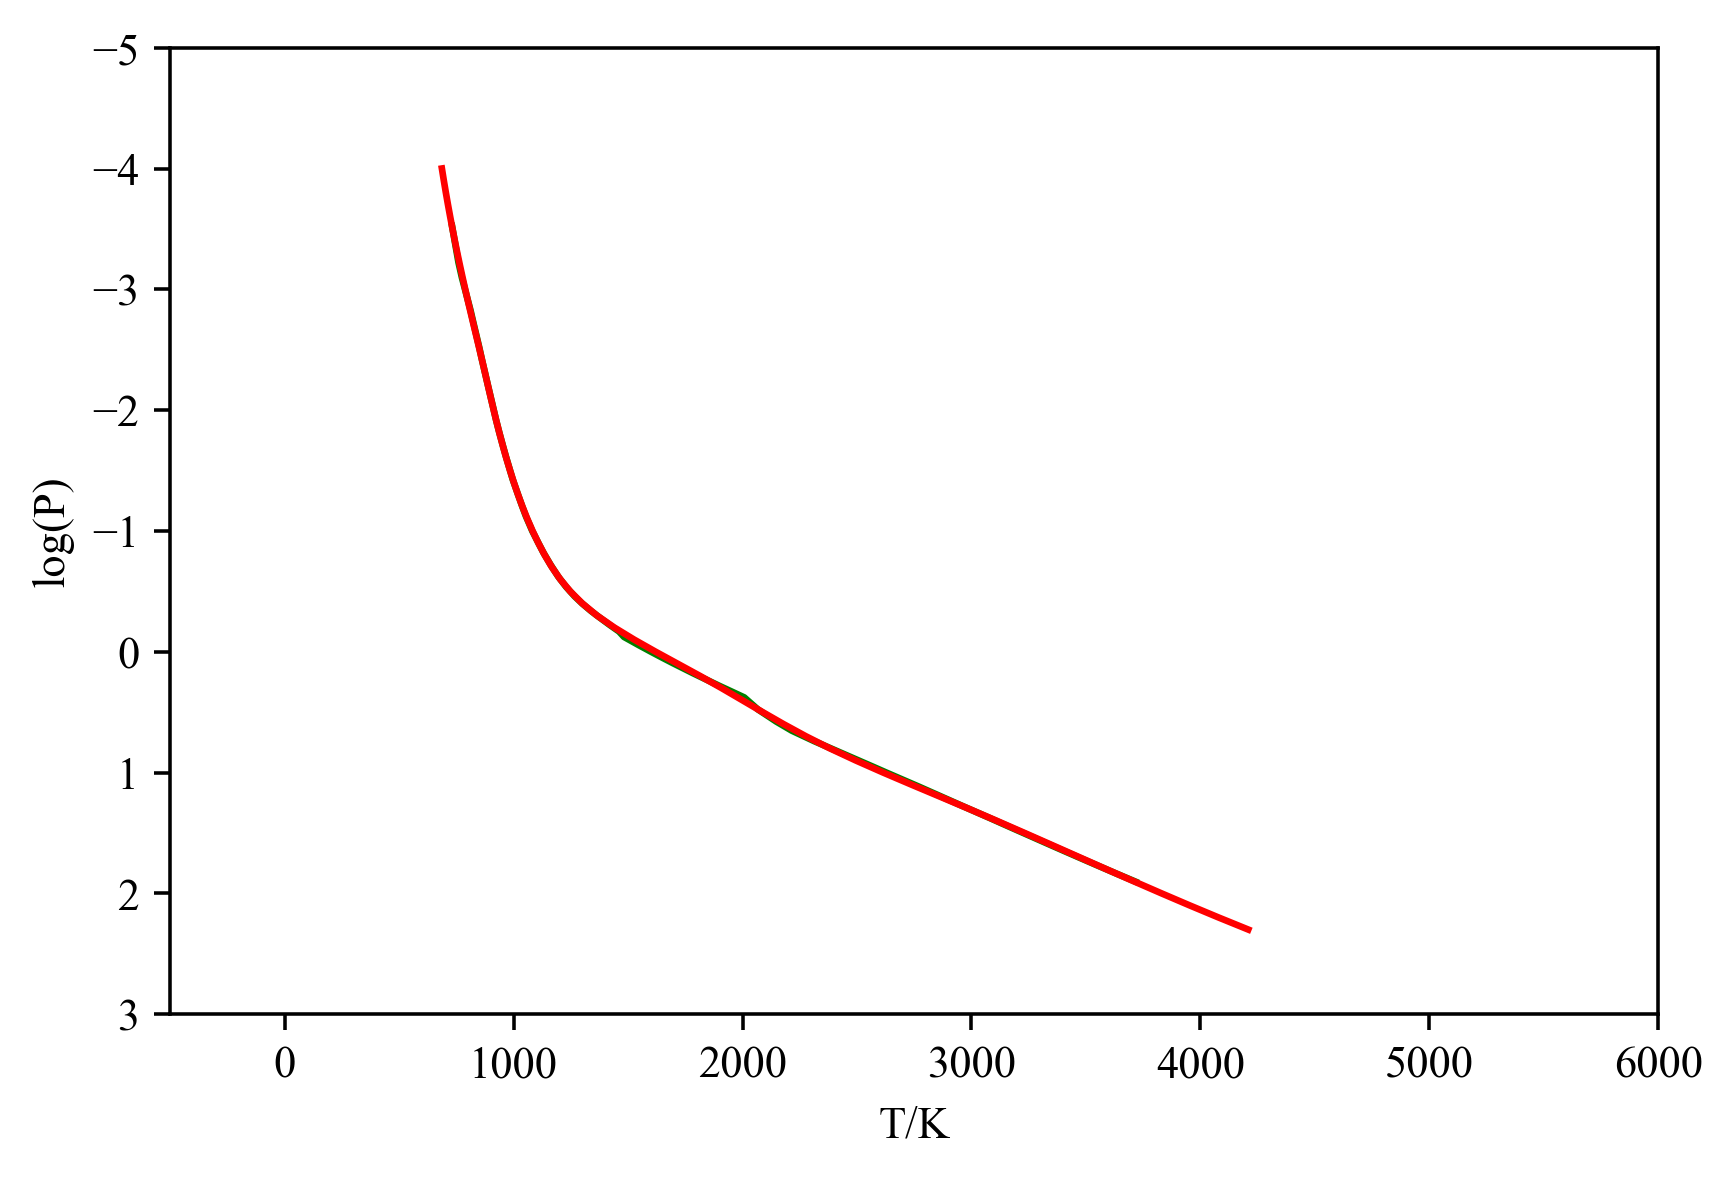

In [15]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([-500., 6000.,3.0,-5.0])
#plt.plot(prof,logcoarsePress,'k-')
plt.plot(modT,np.log10(modP),'g-')
logP = np.log10(press)
plotT = TPmod.set_prof(proftype,coarsePress,press,prof)
plt.plot(plotT,logP, "r-")

plt.ylabel(r'log(P)')
plt.xlabel('T/K')


In [16]:
LP = testkit.lnprob(theta) #* -2. / (obspec.shape[1] /3.)
#print testkit.lnprob(theta2,*runargs) * -2. / (obspec.shape[1] /3.)
print(LP)

Rj =  1.0063362853255915
M =  22.39076173838315
[M/H] =  0.0
[C/O] =  1.0
logg =  4.757913617535738
R2D2 =  1.5022264668593613e-19
scale1 =  1.0
scale2 =  1.0
Rj =  1.0063362853255915
dlam =  0.0007908067630957387
logf =  -32.53009998493603
logf1 =  -32.03178537666361
logf2 =  -32.03178537666361
logf3 =  -32.03178537666361
2.9023761981744357e-37
9.294255847363244e-30
VMRs =  [-3.79582214 -3.52088822]
ng =  2
sum VMRs =  0.0004613994833024365
cloud_top =  [[-4.        ]
 [ 0.83132545]]
cloud_bot =  [[2.3       ]
 [1.43474213]]
cloud_height =  [[0.1       ]
 [0.60341668]]
loga =  [[ 0.        ]
 [-0.36059074]]
b =  [[0.5       ]
 [0.44513132]]
cloud_tau0 =  [[1.        ]
 [0.85765914]]
w0 =  [[0.5]
 [0.5]]
taupow =  [[0.]
 [0.]]
pcover =  [0.08741014 0.91258986]
sum(pcover) =  1.0
metscale =  [-1.   -0.75 -0.7  -0.5  -0.3  -0.25  0.    0.5   0.7   1.    1.5   1.7
  2.  ]
coscale =  [0.25 0.5  1.   1.5  2.   2.5 ]
press[press.size-1]  =  199.52623149689074
press[0] =  0.0001
-51891996.889

In [ ]:
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.44268837  0.55731163  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.        ]

In [ ]:
pickle.compatible_formats


In [ ]:
#for gas in range (0,ngas):
##    test= pickle.load( open(lists[gas], "rb" ) )[3]
#    test[np.isnan(test)] = 1.0
#    print test[np.where(np.less(test,0))]
print forwardmodel.marv.__doc__

In [ ]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([-8., 2.,3.0,-5.0])
logP = np.log10(press)
plt.plot(np.log10(cloudprof[0,:,0]),logP, "r-")

plt.ylabel(r'log(P)')
plt.xlabel('log10(dtau)')

In [ ]:
import forwardmodel
print forwardmodel.marv.__doc__